# <center>Reinforcement Learning</center>
<center><h1 style="color:blue">Actor-Critic</h1></center>

# Solving Complex Environments

## ENVIRONMENT 1 - Bipedal Walker

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class AC(nn.Module):
    def __init__(self):
        super(AC,self).__init__()
        self.nett=nn.Sequential(
            nn.Linear(24,128),nn.ReLU()
        )
        self.actor=nn.Sequential(
            nn.Linear(128,64),nn.ReLU(),
            nn.Linear(64,4)
        )
        self.critic=nn.Sequential(
            nn.Linear(128,64),nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        x=self.nett(x)
        act_mean=self.actor(x)
        critic_val=self.critic(x)
        return act_mean,critic_val

In [3]:
class AC_agent:
    def __init__(self,env_bipedal,actor_critic,learning_rate=0.001,max_grad_norm=0.5):
        self.env_bipedal=env_bipedal
        self.actor_critic=actor_critic
        self.max_grad_norm=max_grad_norm
        self.optimizer=optim.Adam(self.actor_critic.parameters(),lr=learning_rate)
        self.scheduler=optim.lr_scheduler.StepLR(self.optimizer,step_size=1000,gamma=0.9)

    def select_action(self,stt):
        stt=torch.from_numpy(stt).float().unsqueeze(0)
        action_mean,_=self.actor_critic(stt)
        m=Normal(action_mean,torch.tensor(0.1))
        act=m.sample()
        return act.squeeze().numpy()

    def update(self,log_probs,values,rwds):
        returns=self.compute_returns(rwds)
        policy_losses=[]
        value_losses=[]
        for log_prob,value,R in zip(log_probs,values,returns):
            advantage=R - value.item()
            policy_losses.append(-log_prob * advantage)
            value_losses.append(F.smooth_l1_loss(value,torch.tensor([R])))
        self.optimizer.zero_grad()
        loss=torch.stack(policy_losses).sum()+torch.stack(value_losses).sum()
        loss.backward()
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(),self.max_grad_norm)
        self.optimizer.step()
        self.scheduler.step() 

    def train(self,num_episodes):
        all_rwds=[]
        for episode in range(num_episodes):
            stt=self.env_bipedal.reset()
            done=False
            log_probs=[]
            values=[]
            rwds=[]
            while not done:
                if isinstance(stt,tuple):
                    stt=stt[0]
                state_tensor=torch.from_numpy(stt).float().unsqueeze(0)
                action_mean,value=self.actor_critic(state_tensor)
                m=Normal(action_mean,torch.tensor(0.1))
                act=m.sample()
                log_prob=m.log_prob(act)
                next_state,reward,ter,tru,_=self.env_bipedal.step(act.squeeze().numpy())
                done=ter or tru
                log_probs.append(log_prob)
                values.append(value)
                rwds.append(reward)
                stt=next_state
            self.update(log_probs,values,rwds)
            total_reward=sum(rwds)
            all_rwds.append(total_reward)
            print(f"Episode {episode+1}/{num_episodes}: Total Reward={total_reward}")
        return all_rwds

    def compute_returns(self,rwds,gamma=0.99):
        R=0
        returns=[]
        for step in reversed(range(len(rwds))):
            R=rwds[step]+gamma * R
            returns.insert(0,R)
        return returns

In [4]:
env_bipedal=gym.make('BipedalWalker-v3')

In [5]:
ac_model=AC()

In [6]:
agent=AC_agent(env_bipedal=env_bipedal, actor_critic=ac_model)

In [7]:
all_rwds=agent.train(num_episodes=3000)

/scratch/15667023/ipykernel_1223107/2312495111.py:23: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value,torch.tensor([R])))


Episode 1/3000: Total Reward=-111.4604546948721
Episode 2/3000: Total Reward=-100.11375985883487
Episode 3/3000: Total Reward=-95.74060463520155
Episode 4/3000: Total Reward=-93.54760611649354
Episode 5/3000: Total Reward=-94.81156855329374
Episode 6/3000: Total Reward=-93.69078069497459
Episode 7/3000: Total Reward=-92.96683801174163
Episode 8/3000: Total Reward=-93.29673870134974
Episode 9/3000: Total Reward=-93.96164502056378
Episode 10/3000: Total Reward=-93.29514302293025
Episode 11/3000: Total Reward=-92.4143426270651
Episode 12/3000: Total Reward=-95.1337667945878
Episode 13/3000: Total Reward=-93.50007555658743
Episode 14/3000: Total Reward=-95.5056634271834
Episode 15/3000: Total Reward=-95.79681292716475
Episode 16/3000: Total Reward=-95.56906389621398
Episode 17/3000: Total Reward=-95.33560653264573
Episode 18/3000: Total Reward=-95.3972322743532
Episode 19/3000: Total Reward=-96.80240867716198
Episode 20/3000: Total Reward=-95.91694789701948
Episode 21/3000: Total Reward=-9

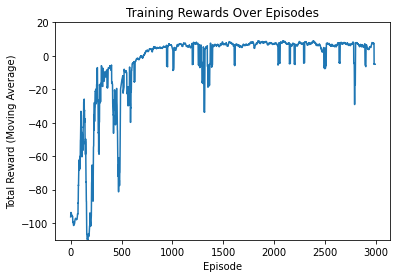

In [20]:
def moving_average(data, window_size):
    c=[0]
    moving_aves=[]
    for i, x in enumerate(data, 1):
        c.append(c[i-1] + x)
        if i >= window_size:
            moving_ave=(c[i]-c[i-window_size]) / window_size
            moving_aves.append(moving_ave)
    return moving_aves

window_size=10
moving_avg_rewards=moving_average(all_rwds, window_size)
plt.plot(moving_avg_rewards)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward (Moving Average)')
plt.ylim(-110, 20)
plt.show()

In [9]:
def evaluate_model(env,model,num_episodes=10):
    all_rwds=[]
    for epi in range(num_episodes):
        stt,_=env.reset()
        done=False
        tot_rwd=0
        while not done:
            stt_tensor=torch.from_numpy(stt).float().unsqueeze(0)
            act_mean,_=model(stt_tensor)
            act=act_mean.detach().numpy().squeeze() # Choose the greedy act,without noise
            nxt_stt,reward,ter,tru,_=env.step(act)
            done=ter or tru
            tot_rwd += reward
            stt=nxt_stt
        all_rwds.append(tot_rwd)
        print(f"Episode {epi+1}/{num_episodes}: Total reward={tot_rwd}")
    return all_rwds

In [10]:
evaluation_rewards=evaluate_model(env_bipedal,ac_model,num_episodes=10)

Episode 1/10: Total reward=14.902422981751478
Episode 2/10: Total reward=18.747983042020998
Episode 3/10: Total reward=15.05762438129262
Episode 4/10: Total reward=18.32016282461892
Episode 5/10: Total reward=19.515128118341174
Episode 6/10: Total reward=19.618964645997295
Episode 7/10: Total reward=18.94538330303878
Episode 8/10: Total reward=20.470307188124746
Episode 9/10: Total reward=14.49928539407814
Episode 10/10: Total reward=17.694833305160216


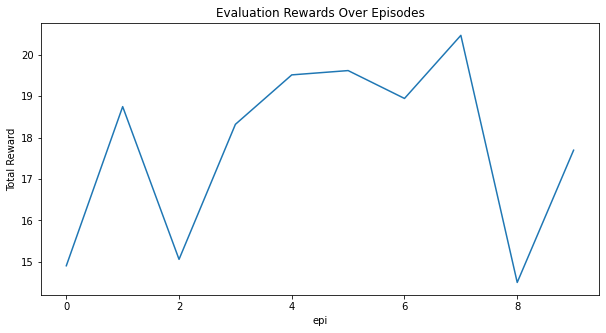

In [11]:
plt.figure(figsize=(10,5))
plt.plot(evaluation_rewards)
plt.title('Evaluation Rewards Over Episodes')
plt.xlabel('epi')
plt.ylabel('Total Reward')
plt.show()

In [12]:
torch.save(ac_model.state_dict(),'part2_env1_bipedal_model.pth')